Import data

In [44]:
import pandas as pd

# 1. Segmentation
print("Segmentation")
df_seg = pd.read_csv('Data/2017Segmentation3685case.csv', sep=';', on_bad_lines='skip')
df_seg.columns = df_seg.columns.str.strip()

# 2. Brand_Image
print("Brand_Image")
df_image = pd.read_csv('Data/Brand_Image.csv', sep=';', on_bad_lines='skip')
df_image.columns = df_image.columns.str.strip()

# 3. Brand_Health
print("Brand_Health")
df_health = pd.read_csv(
    'Data/Brandhealth.csv',
    sep=';',
    on_bad_lines='skip',
    low_memory=False
)
df_health.columns = df_health.columns.str.strip()

# 4. Companion
print("Companion")
df_companion = pd.read_csv('Data/Companion.csv', sep=';', on_bad_lines='skip')
df_companion.columns = df_companion.columns.str.strip()

# 5. Competitor
print("Competitor")
df_competitor = pd.read_csv('Data/Competitor database_xlnm#_FilterDatabase.csv', sep=';', on_bad_lines='skip')
df_competitor.columns = df_competitor.columns.str.strip()

# 6. Dayofweek
print("Dayofweek")
df_dow = pd.read_csv('Data/Dayofweek.csv', sep=';', on_bad_lines='skip')
df_dow.columns = df_dow.columns.str.strip()

# 7. Daypart
print("Daypart")
df_daypart = pd.read_csv('Data/Daypart.csv', sep=';', on_bad_lines='skip')
df_daypart.columns = df_daypart.columns.str.strip()

# 8. Needstate
print("Needstate")
df_need = pd.read_csv('Data/NeedstateDayDaypart.csv', sep=';', on_bad_lines='skip')
df_need.columns = df_need.columns.str.strip()

# 9. SA_var
print("SA_var")
df_sa = pd.read_csv('Data/SA#var.csv', sep=';', on_bad_lines='skip')
df_sa.columns = df_sa.columns.str.strip()

Segmentation
Brand_Image
Brand_Health
Companion
Competitor
Dayofweek
Daypart
Needstate
SA_var


In [45]:
# 🔁 Tạo dict mapping ID -> (City, Year) từ df_sa
id_map = df_sa.set_index('ID')[['City', 'Year']].dropna().astype(str)

# 🧠 Hàm kiểm tra từng dataframe
def check_consistency(df, name):
    df = df[['ID', 'City', 'Year']].dropna().astype(str)
    df = df[df['ID'].isin(id_map.index)]
    merged = df.merge(id_map, on='ID', suffixes=('', '_sa'))
    mismatch = merged[(merged['City'] != merged['City_sa']) | (merged['Year'] != merged['Year_sa'])]
    
    if not mismatch.empty:
        print(f"❌ Inconsistent City/Year found in {name}: {len(mismatch)} mismatches")
        display(mismatch.head())
    else:
        print(f"✅ {name} is consistent with SA#var")

# 📋 Danh sách sheet cần kiểm
sheets = {
    'Brand_Image': df_image,
    'Brand_Health': df_health,
    'Companion': df_companion,
    'Dayofweek': df_dow,
    'Daypart': df_daypart,
    'NeedstateDayDaypart': df_need,
}

# 🔍 Chạy kiểm tra
for name, df in sheets.items():
    check_consistency(df, name)
def clean_brand_columns(df, columns, replace_map, name="DataFrame"):
    """
    Chuẩn hoá các cột thương hiệu trong DataFrame:
    - Viết thường
    - Xoá khoảng trắng
    - Thay thế các biến thể thương hiệu theo bản đồ thay thế

    Args:
        df (pd.DataFrame): DataFrame cần xử lý
        columns (list): Danh sách tên cột cần xử lý
        replace_map (dict): Từ điển ánh xạ giá trị cần thay thế
        name (str): Tên bảng để in log
    """
    for col in columns:
        if col not in df.columns:
            print(f"⚠️  Cột '{col}' không tồn tại trong {name}")
            continue

        print(f"\n🔎 Unique values in '{col}' BEFORE cleaning ({name}):")
        print(df[col].dropna().unique())

        df[col] = df[col].str.lower().str.strip()
        df[col] = df[col].replace(replace_map)

        print(f"✅ Unique values in '{col}' AFTER cleaning ({name}):")
        print(df[col].dropna().unique())


✅ Brand_Image is consistent with SA#var
✅ Brand_Health is consistent with SA#var
✅ Companion is consistent with SA#var
✅ Dayofweek is consistent with SA#var
✅ Daypart is consistent with SA#var
✅ NeedstateDayDaypart is consistent with SA#var


In [46]:
import os
import pandas as pd

# 📂 Tạo thư mục output nếu chưa tồn tại
output_dir = "./cleaned_data/"
os.makedirs(output_dir, exist_ok=True)

# 📌 Map chuẩn hóa brand để dùng chung
brand_replace_map = {
    'street / half street coffee (including carts)': 'street',
    'Street / Half street coffee (including carts)': 'street',
    'other branded cafe chain': 'other',
    'other 1': 'other',
    'other 2': 'other',
    'other 3': 'other',
    'indepedent cafe': 'independent cafe'
}

# 🧹 Hàm chuẩn hoá cột brand
def clean_brand_columns(df, columns, replace_map, sheet_name):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].str.lower().str.strip()
            df[col] = df[col].replace(replace_map)
            print(f"🔧 Chuẩn hoá cột {col} trong bảng {sheet_name}")

# 🧠 Hàm tách ngày và thời gian trong NeedstateDayDaypart
def clean_day_daypart(val):
    val = str(val).strip().lower()
    if val in ['overall', 'weekdays', 'weekends']:
        return pd.Series({'DayGroup': val, 'Daypart_cleaned': None})
    else:
        return pd.Series({'DayGroup': None, 'Daypart_cleaned': val})

# 🧠 Hàm chuẩn hoá needstates
def standardize_needstate(val):
    val = str(val).strip().lower()
    typo_map = {
        'socialzing': 'socializing with others',
        'enterntainment (watching movies. playing games, browsing web,…)': 'entertainment',
        'enterntainment': 'entertainment'
    }
    val = typo_map.get(val, val)
    needstate_map = {
        'socializing with colleagues': 'socializing with others',
        'socializing with family / relatives': 'socializing with others',
        'socializing with friends': 'socializing with others',
        'drinking coffee': 'drinking',
        'drinking tea': 'drinking',
        'drinking ice-blended': 'drinking',
        'drinking other beverages (excluding tea, coffee, freeze)': 'drinking',
        'entertainment': 'entertainment',
        'relaxing (alone)': 'relaxing',
        'have meals (breakfast / lunch / dinner)': 'eating',
        'have snack / pastry': 'eating',
        'working / business meeting': 'working',
        'studying / reading books': 'studying'
    }
    return needstate_map.get(val, val)

# 📦 Hàm xử lý tất cả các bảng
def process_df(df, name, drop_cols=['City', 'Year']):
    print(f"\n📄 Đang xử lý: {name}")
    print(f"🔍 Số dòng trùng lặp: {df.duplicated().sum()}")

    df_clean = df.drop_duplicates()

    if df.shape[0] != df_clean.shape[0]:
        print(f"✅ Đã loại bỏ {df.shape[0] - df_clean.shape[0]} dòng trùng lặp")

    for col in drop_cols:
        if col in df_clean.columns:
            df_clean = df_clean.drop(columns=col)
            print(f"🗑 Đã loại cột: {col}")

    if name == "SA_var":
        cols_to_drop = ['MPI_Mean_Use','MPI#detail','MPI','Age#group','Col']
        df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])
        brand_columns = ['TOM','BUMO','MostFavourite']
        clean_brand_columns(df_clean, brand_columns, brand_replace_map, name)
        print("🗑 Đã loại các cột dư thừa đặc biệt")

    elif name == "Brand_Image":
        if 'Attribute' in df_clean.columns:
            df_clean['Attribute'] = df_clean['Attribute'].str.lower().str.strip()
            df_clean['Attribute'] = df_clean['Attribute'].replace({
                'good place for working / business meeting': 'good place for working',
                'good place for working / studying': 'good place for working',
                'good place for socializing with friends': 'good place for socializing',
                'good place for socializing with family': 'good place for socializing',
                'good place for socializing with colleagues': 'good place for socializing',
                'nice environment design': 'pleasant environment',
                'comfortable and relaxing environment': 'pleasant environment',
                'good other beverages (other than coffee, tea & ice-blended)': 'good other beverages',
                'have new product regularly': 'frequent product updates',
                'feel i belong here': 'sense of belonging',
                'delicious food': 'good food taste'
            })
            print("🔧 Đã chuẩn hoá cột Attribute")

        for col in ['Awareness', 'BrandImage']:
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].str.lower().str.strip()
                df_clean[col] = df_clean[col].replace(brand_replace_map)
                print(f"🔧 Đã chuẩn hoá cột {col}")

    elif name == "Brand_Health":
        brand_columns = ['Brand', 'Awareness', 'Spontaneous', 'Trial', 'P3M', 'P1M', 'Weekly', 'Daily']
        clean_brand_columns(df_clean, brand_columns, brand_replace_map, name)

    # elif name == "NeedstateDayDaypart":
    #     if 'Day#Daypart' in df_clean.columns:
    #         df_daypart_split = df_clean['Day#Daypart'].apply(clean_day_daypart).apply(pd.Series)
    #         df_clean = pd.concat([df_clean, df_daypart_split], axis=1)
    #         df_clean.drop(columns=['Day#Daypart'], inplace=True)
    #         print("🔧 Đã tách cột Day#Daypart thành DayGroup & Daypart_cleaned")

    #     if 'Needstates' in df_clean.columns:
    #         df_clean['Needstates_standardized'] = df_clean['Needstates'].apply(standardize_needstate)
    #         print("🔧 Đã chuẩn hoá cột Needstates")
            
    #     df_clean = df_clean.drop(columns=['Needstates'])

    # 💾 Ghi file ra
    output_path = os.path.join(output_dir, f"{name}_cleaned.csv")
    df_clean.to_csv(output_path, index=False)
    print(f"💾 Đã lưu: {name}_cleaned.csv")

# ✨ Gọi xử lý cho từng file
process_df(df_seg, "Segmentation", drop_cols=[])  
process_df(df_image, "Brand_Image")
process_df(df_health, "Brand_Health")
process_df(df_companion, "Companion")
process_df(df_competitor, "Competitor", drop_cols=[])  
process_df(df_dow, "Dayofweek")
process_df(df_daypart, "Daypart")
process_df(df_need, "NeedstateDayDaypart")
process_df(df_sa, "SA_var", drop_cols=[])



📄 Đang xử lý: Segmentation
🔍 Số dòng trùng lặp: 0
💾 Đã lưu: Segmentation_cleaned.csv

📄 Đang xử lý: Brand_Image
🔍 Số dòng trùng lặp: 13974
✅ Đã loại bỏ 13974 dòng trùng lặp
🗑 Đã loại cột: City
🗑 Đã loại cột: Year
🔧 Đã chuẩn hoá cột Attribute
🔧 Đã chuẩn hoá cột Awareness
🔧 Đã chuẩn hoá cột BrandImage
💾 Đã lưu: Brand_Image_cleaned.csv

📄 Đang xử lý: Brand_Health
🔍 Số dòng trùng lặp: 0
🗑 Đã loại cột: City
🗑 Đã loại cột: Year
🔧 Chuẩn hoá cột Brand trong bảng Brand_Health
🔧 Chuẩn hoá cột Awareness trong bảng Brand_Health
🔧 Chuẩn hoá cột Spontaneous trong bảng Brand_Health
🔧 Chuẩn hoá cột Trial trong bảng Brand_Health
🔧 Chuẩn hoá cột P3M trong bảng Brand_Health
🔧 Chuẩn hoá cột P1M trong bảng Brand_Health
🔧 Chuẩn hoá cột Weekly trong bảng Brand_Health
🔧 Chuẩn hoá cột Daily trong bảng Brand_Health
💾 Đã lưu: Brand_Health_cleaned.csv

📄 Đang xử lý: Companion
🔍 Số dòng trùng lặp: 799
✅ Đã loại bỏ 799 dòng trùng lặp
🗑 Đã loại cột: City
🗑 Đã loại cột: Year
💾 Đã lưu: Companion_cleaned.csv

📄 Đang x

In [47]:
import pandas as pd
df = pd.read_csv("./cleaned_data/Brand_Health_cleaned.csv", low_memory=False)
df.columns = df.columns.str.strip().str.lower().str.replace('#', '_')

# Xử lý Not applicable ở weekly & daily
df["weekly"] = df["weekly"].str.strip().str.lower().replace(r"not applicable", pd.NA, regex=True)
df["daily"] = df["daily"].str.strip().str.lower().replace(r"not applicable", pd.NA, regex=True)

df.to_csv("./cleaned_data/Brand_Health_cleaned.csv", index=False)
print("✅ Đã xử lý Brand_Health_cleaned.csv hoàn chỉnh")

✅ Đã xử lý Brand_Health_cleaned.csv hoàn chỉnh


In [48]:
import pandas as pd
import os

# 📂 Thư mục chứa file đã xử lý
cleaned_dir = "./cleaned_data/"

# 📊 Hàm kiểm tra null cho từng cột và in tổng số dòng
def report_nulls(file_path):
    df = pd.read_csv(file_path, sep=',', low_memory=False)
    total_rows = df.shape[0]
    null_info = df.isnull().sum()
    null_percent = (null_info / total_rows * 100).round(2)
    
    null_df = pd.DataFrame({
        "Column": null_info.index,
        "Null Count": null_info.values,
        "Null %": null_percent.values
    })
    
    null_df = null_df[null_df["Null Count"] > 0]

    file_name = os.path.basename(file_path)
    
    if not null_df.empty:
        print(f"\n📁 File: {file_name}")
        print(f"📏 Tổng số dòng: {total_rows}")
        print(null_df.to_string(index=False))
    else:
        print(f"\n✅ File: {file_name} - KHÔNG có giá trị null")
        print(f"📏 Tổng số dòng: {total_rows}")

# 🚀 Quét tất cả file CSV đã xử lý
for fname in os.listdir(cleaned_dir):
    if fname.endswith(".csv"):
        report_nulls(os.path.join(cleaned_dir, fname))




📁 File: Brand_Health_cleaned.csv
📏 Tổng số dòng: 74419
          Column  Null Count  Null %
     spontaneous       43426   58.35
       awareness         114    0.15
           trial       27089   36.40
             p3m       45570   61.23
             p1m       55020   73.93
   comprehension       48073   64.60
brand_likability       64088   86.12
          weekly       63537   85.38
           daily       71966   96.70
       fre_visit       55087   74.02
             ppa       60346   81.09
        spending       60346   81.09
    segmentation       60346   81.09
         nps_p3m       52814   70.97
   nps_p3m_group       52814   70.97
    spending_use       60346   81.09

📁 File: Brand_Image_cleaned.csv
📏 Tổng số dòng: 629098
   Column  Null Count  Null %
Awareness         397    0.06

✅ File: Companion_cleaned.csv - KHÔNG có giá trị null
📏 Tổng số dòng: 19940

✅ File: Competitor_cleaned.csv - KHÔNG có giá trị null
📏 Tổng số dòng: 234

📁 File: Dayofweek_cleaned.csv
📏 Tổng số dòng:

C:\Users\phamh\AppData\Local\Temp\ipykernel_31060\1585891485.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\phamh\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


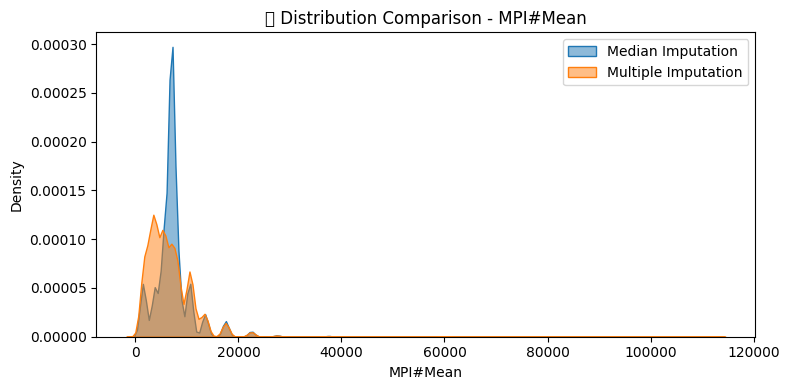

C:\Users\phamh\AppData\Local\Temp\ipykernel_31060\1585891485.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\phamh\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


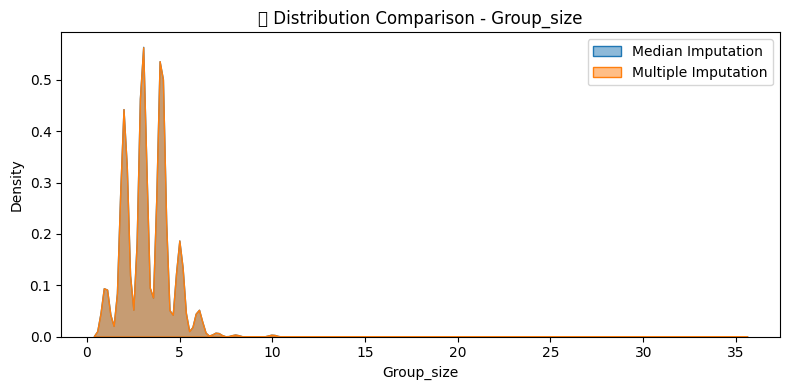

C:\Users\phamh\AppData\Local\Temp\ipykernel_31060\1585891485.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\phamh\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


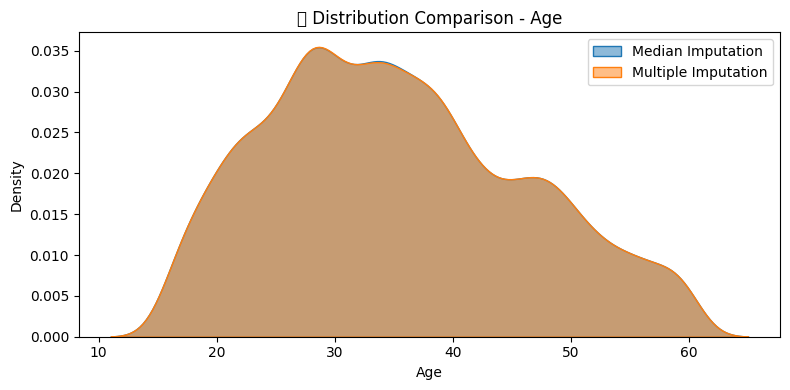

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

# 🔹 Bước 1: Đọc dữ liệu
df = pd.read_csv("./cleaned_data/SA_var_cleaned.csv")

# 🔹 Bước 2: Chọn các cột liên quan
features = [
    'ID', 'City', 'Group_size', 'Age', 'MPI#Mean', 'TOM', 'BUMO',
    'BUMO_Previous', 'MostFavourite', 'Gender', 'Age#Group#2',
    'MPI#2', 'Occupation', 'Occupation#group', 'Year'
]
df = df[features]

# 🔹 Bước 3: Median Imputation (để so sánh)
df_median = df.copy()
numerical_cols = ['Group_size', 'Age', 'MPI#Mean']
df_median[numerical_cols] = df_median[numerical_cols].fillna(df_median[numerical_cols].median())

# 🔹 Bước 4: Multiple Imputation (MI)
df_mi = df.copy()
categorical_cols = [
    'City', 'TOM', 'BUMO', 'BUMO_Previous', 'MostFavourite',
    'Gender', 'Age#Group#2', 'MPI#2', 'Occupation', 'Occupation#group'
]

# Mã hóa các cột phân loại
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_mi[categorical_cols] = encoder.fit_transform(df_mi[categorical_cols])

# Impute cho các biến số và BUMO_Previous
mi_features = ['Group_size', 'Age', 'MPI#Mean', 'BUMO_Previous']
imputer = IterativeImputer(random_state=42)
df_mi[mi_features] = imputer.fit_transform(df_mi[mi_features])

# Làm tròn lại biến phân loại
df_mi['BUMO_Previous'] = np.round(df_mi['BUMO_Previous'])

# 🔹 Bước 5: So sánh phân phối
for col in ['MPI#Mean', 'Group_size', 'Age']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_median[col], label='Median Imputation', fill=True, alpha=0.5)
    sns.kdeplot(df_mi[col], label='Multiple Imputation', fill=True, alpha=0.5)
    plt.title(f"📊 Distribution Comparison - {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔹 (Tùy chọn) Lưu kết quả Multiple Imputation
df_mi.to_csv("cleaned_data/SA_var_cleaned.csv", index=False)


In [50]:
import pandas as pd
import numpy as np

# ─────────────────────────────
# 🔹 Bước 1: Dayofweek_cleaned.csv
# ─────────────────────────────
df_day = pd.read_csv("./cleaned_data/Dayofweek_cleaned.csv")
print(f"\n📁 Dayofweek_cleaned.csv - Trước: {df_day.shape[0]} dòng")

df_day.dropna(inplace=True)

print(f"✅ Sau khi dropna: {df_day.shape[0]} dòng còn lại")
df_day.to_csv("./cleaned_data/Dayofweek_cleaned.csv", index=False)

# ─────────────────────────────
# 🔹 Bước 2: SA_var_cleaned.csv
# ─────────────────────────────
df = pd.read_csv("./cleaned_data/SA_var_cleaned.csv")
df.columns = df.columns.str.strip()

# 🧠 Hàm phân nhóm tuổi
def map_age_group(age):
    if age <= 19: return '16 - 19 y.o.'
    elif age <= 24: return '20 - 24 y.o.'
    elif age <= 29: return '25 - 29 y.o.'
    elif age <= 34: return '30 - 34 y.o.'
    elif age <= 39: return '35 - 39 y.o.'
    elif age <= 44: return '40 - 44 y.o.'
    else: return '45+ y.o.'

df["Age#Group#2"] = df["Age"].apply(map_age_group)

# 🧠 Hàm phân nhóm MPI
def map_mpi_category(mpi):
    if pd.isna(mpi): return np.nan
    if mpi < 4500: return "1.Under VND 4.5m"
    elif mpi < 9000: return "2.VND 4.5m - VND 8.9m"
    elif mpi < 15000: return "3.VND 9m - VND 14.9m"
    elif mpi < 25000: return "4.VND 15m - VND 24.9m"
    else: return "5.VND 25m+"

df["MPI#2"] = df["MPI#Mean"].apply(map_mpi_category)
df["BUMO_Previous"] = df["BUMO_Previous"].fillna("No")

df.to_csv("./cleaned_data/SA_var_cleaned.csv", index=False)
print("✅ Đã xử lý SA_var_cleaned.csv")

# ─────────────────────────────
# 🔹 Bước 3: Brand_Image_cleaned.csv
# ─────────────────────────────
df = pd.read_csv("./cleaned_data/Brand_Image_cleaned.csv")
df.columns = df.columns.str.strip()

null_count = df["Awareness"].isnull().sum()
print(f"\n📁 Brand_Image_cleaned.csv — Null Awareness: {null_count}")

# Nếu có BrandImage → gán lại cho Awareness
df.loc[df["Awareness"].isnull() & df["BrandImage"].notnull(), "Awareness"] = df["BrandImage"]
df["Awareness"] = df["Awareness"].fillna("Unaware")

df.to_csv("./cleaned_data/Brand_Image_cleaned.csv", index=False)
print("✅ Đã xử lý Brand_Image_cleaned.csv")

# ─────────────────────────────
# 🔹 Bước 4: Daypart_cleaned.csv
# ─────────────────────────────
df = pd.read_csv("./cleaned_data/Daypart_cleaned.csv")
print(f"\n📁 Daypart_cleaned.csv — {df.shape[0]} dòng")

# Điền Daypart bằng mode
df["Daypart"] = df["Daypart"].fillna(df["Daypart"].mode()[0])

# Điền Visit#Daypart theo median nhóm
df["Visit#Daypart"] = df.groupby("Daypart")["Visit#Daypart"].transform(lambda x: x.fillna(x.median()))
df["Visit#Daypart"] = df["Visit#Daypart"].fillna(df["Visit#Daypart"].median())

df.to_csv("./cleaned_data/Daypart_cleaned.csv", index=False)
print("✅ Đã xử lý Daypart_cleaned.csv")




📁 Dayofweek_cleaned.csv - Trước: 39058 dòng
✅ Sau khi dropna: 38955 dòng còn lại
✅ Đã xử lý SA_var_cleaned.csv

📁 Brand_Image_cleaned.csv — Null Awareness: 397
✅ Đã xử lý Brand_Image_cleaned.csv

📁 Daypart_cleaned.csv — 19189 dòng
✅ Đã xử lý Daypart_cleaned.csv


In [51]:
# ─────────────────────────────
# 🔹 Bước 5: Brand_Health_cleaned.csv
# ─────────────────────────────
df = pd.read_csv("./cleaned_data/Brand_Health_cleaned.csv", low_memory=False)
df.columns = df.columns.str.strip().str.lower().str.replace('#', '_')


# Gán awareness từ spontaneous nếu thiếu
df.loc[df["awareness"].isnull() & df["spontaneous"].notnull(), "awareness"] = df["spontaneous"]
df["spontaneous"] = df["spontaneous"].fillna("unaware").astype(str).str.strip().str.lower()
df["awareness"] = df["awareness"].fillna("unaware").astype(str).str.strip().str.lower()

# Chuẩn hóa trước
df["spontaneous"] = df["spontaneous"].fillna("unaware").str.strip().str.lower()
df["awareness"] = df["awareness"].fillna("unaware").str.strip().str.lower()

# Chuyển thành nhị phân: 1 nếu biết brand, 0 nếu unaware
# Nếu muốn cột spontaneous chỉ là 0/1
df["spontaneous"] = df["spontaneous"].apply(lambda x: 0 if x == "unaware" else 1)
df["awareness"] = df["awareness"].apply(lambda x: 0 if x == "unaware" else 1)

# Chuyển các mốc trial về nhị phân
df["trial"] = df["trial"].notnull().astype(int)
df["p3m"] = df["p3m"].notnull().astype(int)
df["p1m"] = df["p1m"].notnull().astype(int)
df["weekly"] = df["weekly"].notnull().astype(int)
df["daily"] = df["daily"].notnull().astype(int)
# Logic liên kết
df.loc[(df["p3m"] == 1) & (df["trial"] == 0), "trial"] = 1
df.loc[df["p1m"] == 1, "trial"] = 1
df.loc[(df["p1m"] == 1) & (df["p3m"] == 0), "p3m"] = 1

# Tính toán spending/ppa/fre_visit
mask1 = df["fre_visit"].notnull() & df["spending"].notnull()
df.loc[mask1, "ppa"] = df["spending"] / df["fre_visit"]

df.loc[df["fre_visit"].isnull(), ["fre_visit", "ppa", "spending", "spending_use"]] = 0

mask2 = df["fre_visit"].notnull() & df["ppa"].notnull() & df["spending"].isnull()
df.loc[mask2, "spending"] = df["fre_visit"] * df["ppa"]

mask3 = df["fre_visit"].notnull() & df["spending"].notnull() & df["ppa"].isnull()
df.loc[mask3, "ppa"] = df["spending"] / df["fre_visit"]

mask4 = df["ppa"].notnull() & df["spending"].notnull() & df["fre_visit"].isnull()
df.loc[mask4, "fre_visit"] = df["spending"] / df["ppa"]


# Điền thiếu còn lại
df["ppa"] = df["ppa"].fillna(df["ppa"].median())
df["spending"] = df["spending"].fillna(df["ppa"] * df["fre_visit"])
df["spending_use"] = df["spending_use"].fillna(df["spending"])

# Ghi lại
df.to_csv("./cleaned_data/Brand_Health_cleaned.csv", index=False)
print("✅ Đã xử lý Brand_Health_cleaned.csv hoàn chỉnh")


✅ Đã xử lý Brand_Health_cleaned.csv hoàn chỉnh


In [32]:
import pandas as pd


# Đọc file
df = pd.read_csv("cleaned_data/NeedstateDayDaypart_cleaned.csv")
df.columns = df.columns.str.strip().str.lower().str.replace('#', '_')

# 2️⃣ Needstates có nhưng thiếu needstategroup
needstate_logic_mismatch = df[(df["needstates"].notnull()) & (df["needstategroup"].isnull())]
print(f"❗ Có {len(needstate_logic_mismatch)} dòng có Needstates nhưng thiếu NeedstateGroup")


# Đọc dữ liệu
df = pd.read_csv("cleaned_data/Competitor_cleaned.csv")
df.columns = df.columns.str.strip().str.lower().str.replace('#', '_')

print("\n🔍 Kiểm tra logic bảng: Competitor Database")

# 1️⃣ storecount phải là số nguyên và không âm
storecount_invalid = df[(df["storecount"] < 0) | (df["storecount"].isnull())]
print(f"❗ Dòng có storecount < 0 hoặc thiếu: {len(storecount_invalid)}")

import pandas as pd

# Đọc dữ liệu
dayofweek = pd.read_csv("cleaned_data/Dayofweek_cleaned.csv")
daypart = pd.read_csv("cleaned_data/Daypart_cleaned.csv")

# Chuẩn hóa tên cột
dayofweek.columns = dayofweek.columns.str.strip().str.lower().str.replace('#', '_')
daypart.columns = daypart.columns.str.strip().str.lower().str.replace('#', '_')

# ----------- Kiểm tra Dayofweek.csv -----------

# 1️⃣ Kiểm tra dayofweek có đúng tên thứ không
valid_days = {"monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"}
invalid_day_names = dayofweek[~dayofweek["dayofweek"].str.lower().isin(valid_days)]

# 2️⃣ Kiểm tra visit_dayofweek có giá trị không âm và không null
invalid_visits = dayofweek[(dayofweek["visit_dayofweek"].isnull()) | (dayofweek["visit_dayofweek"] < 0)]

# 3️⃣ Kiểm tra weakday_end có khớp với dayofweek
def map_weekgroup(day):
    return "Weekend" if day.lower() in ["saturday", "sunday"] else "Weekdays"

dayofweek["expected_group"] = dayofweek["dayofweek"].str.lower().apply(map_weekgroup)
wrong_group = dayofweek[dayofweek["weekday_end"].str.lower() != dayofweek["expected_group"].str.lower()]

❗ Có 0 dòng có Needstates nhưng thiếu NeedstateGroup

🔍 Kiểm tra logic bảng: Competitor Database
❗ Dòng có storecount < 0 hoặc thiếu: 0


In [33]:
import pandas as pd

# Đọc dữ liệu
df = pd.read_csv("cleaned_data/SA_var_cleaned.csv")
df.columns = df.columns.str.strip().str.lower().str.replace('#', '_')

# 🔹 Group_size không hợp lệ
invalid_group_size = df[(df["group_size"].isnull()) | (df["group_size"] < 1)]
print("❌ Group_size không hợp lệ:")
print(invalid_group_size[["id", "group_size"]].head(15), "\n")

# 🔹 Age group không khớp với tuổi
def map_age_group(age):
    if age <= 19: return '16 - 19 y.o.'
    elif age <= 24: return '20 - 24 y.o.'
    elif age <= 29: return '25 - 29 y.o.'
    elif age <= 34: return '30 - 34 y.o.'
    elif age <= 39: return '35 - 39 y.o.'
    elif age <= 44: return '40 - 44 y.o.'
    else: return '45+ y.o.'

df["expected_age_group"] = df["age"].apply(map_age_group)
age_group_mismatch = df[df["age_group_2"] != df["expected_age_group"]]
print("❌ Age group không khớp với Age:")
print(age_group_mismatch[["id", "age", "age_group_2", "expected_age_group"]].head(10), "\n")

# 🔹 MPI group không khớp với MPI_mean
def map_mpi_group(mpi):
    if mpi < 4500: return "1.Under VND 4.5m"
    elif mpi < 9000: return "2.VND 4.5m - VND 8.9m"
    elif mpi < 15000: return "3.VND 9m - VND 14.9m"
    elif mpi < 25000: return "4.VND 15m - VND 24.9m"
    else: return "5.VND 25m+"

df["expected_mpi_2"] = df["mpi_mean"].apply(map_mpi_group)
mpi_group_mismatch = df[df["mpi_2"] != df["expected_mpi_2"]]
print("❌ MPI group không khớp với MPI_Mean:")
print(mpi_group_mismatch[["id", "mpi_mean", "mpi_2", "expected_mpi_2"]].head(10), "\n")

# 🔹 TOM, BUMO, MostFavourite đều trùng nhau
same_brand_all = df[
    (df["tom"].notnull()) & 
    (df["bumo"].notnull()) & 
    (df["mostfavourite"].notnull()) & 
    (df["tom"] == df["bumo"]) & 
    (df["bumo"] == df["mostfavourite"])
]

❌ Group_size không hợp lệ:
Empty DataFrame
Columns: [id, group_size]
Index: [] 

❌ Age group không khớp với Age:
Empty DataFrame
Columns: [id, age, age_group_2, expected_age_group]
Index: [] 

❌ MPI group không khớp với MPI_Mean:
Empty DataFrame
Columns: [id, mpi_mean, mpi_2, expected_mpi_2]
Index: [] 



In [53]:
import pandas as pd
import os

# Đường dẫn thư mục chứa file
data_dir = "cleaned_data/"

# Đọc ID từ bảng gốc (bảng chính)
sa = pd.read_csv(os.path.join(data_dir, "SA_var_cleaned.csv"))
sa.columns = sa.columns.str.strip().str.lower()
valid_ids = set(sa["id"].dropna().unique())

# Danh sách các file cần kiểm tra ID
files_to_check = [
    "Brand_Health_cleaned.csv",
    "Brand_Image_cleaned.csv",
    "Companion_cleaned.csv",
    "Dayofweek_cleaned.csv",
    "Daypart_cleaned.csv",
    "NeedstateDayDaypart_cleaned.csv"
]

# Lưu kết quả lỗi
missing_id_report = []

# Lặp qua từng file và kiểm tra ID
for file_name in files_to_check:
    path = os.path.join(data_dir, file_name)
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    
    if "id" in df.columns:
        ids = set(df["id"].dropna().unique())
        missing_ids = ids - valid_ids
        if missing_ids:
            missing_id_report.append({
                "file": file_name,
                "missing_count": len(missing_ids),
                "sample_missing_ids": list(missing_ids)[:5]  # in mẫu 5 ID
            })

# In kết quả
if missing_id_report:
    print("❌ Một số file có ID không tồn tại trong SA_var_cleaned.csv:")
    for report in missing_id_report:
        print(f"📁 {report['file']}: thiếu {report['missing_count']} ID")
        print(f"   → Ví dụ ID thiếu: {report['sample_missing_ids']}")
else:
    print("✅ Tất cả các ID đều có mặt trong SA_var_cleaned.csv")


C:\Users\phamh\AppData\Local\Temp\ipykernel_31060\1711239559.py:28: DtypeWarning: Columns (8,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


✅ Tất cả các ID đều có mặt trong SA_var_cleaned.csv


In [54]:
import os
import pandas as pd

# Đường dẫn tới thư mục chứa các file đã làm sạch
data_dir = "cleaned_data"

# Duyệt tất cả các file trong thư mục
for filename in os.listdir(data_dir):
    # Chỉ xét các file CSV (hoặc đổi điều kiện nếu là định dạng khác)
    if filename.endswith(".csv"):
        file_path = os.path.join(data_dir, filename)
        try:
            df = pd.read_csv(file_path)
            print(f"📁 File: {filename}")
            print("➡️ Features:", list(df.columns))
            print("-" * 80)
        except Exception as e:
            print(f"⚠️ Lỗi đọc file {filename}: {e}")


C:\Users\phamh\AppData\Local\Temp\ipykernel_31060\2020792781.py:13: DtypeWarning: Columns (8,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


📁 File: Brand_Health_cleaned.csv
➡️ Features: ['id', 'brand', 'spontaneous', 'awareness', 'trial', 'p3m', 'p1m', 'comprehension', 'brand_likability', 'weekly', 'daily', 'fre_visit', 'ppa', 'spending', 'segmentation', 'nps_p3m', 'nps_p3m_group', 'spending_use']
--------------------------------------------------------------------------------
📁 File: Brand_Image_cleaned.csv
➡️ Features: ['ID', 'Awareness', 'Attribute', 'BrandImage']
--------------------------------------------------------------------------------
📁 File: Companion_cleaned.csv
➡️ Features: ['ID', 'Companion#group']
--------------------------------------------------------------------------------
📁 File: Competitor_cleaned.csv
➡️ Features: ['No#', 'Brand', 'City', 'Year', 'StoreCount']
--------------------------------------------------------------------------------
📁 File: Dayofweek_cleaned.csv
➡️ Features: ['ID', 'Dayofweek', 'Visit#Dayofweek', 'Weekday#end']
------------------------------------------------------------------

In [55]:
import pandas as pd

# Đọc dữ liệu
df_seg = pd.read_csv("cleaned_data/Segmentation_cleaned.csv")
df_health = pd.read_csv("cleaned_data/Brand_Health_cleaned.csv")
df_sa = pd.read_csv("cleaned_data/SA_var_cleaned.csv")

# Chuẩn hóa tên cột về chữ thường để tránh lỗi
df_health.columns = df_health.columns.str.lower()
df_seg.columns = df_seg.columns.str.lower()
df_sa.columns = df_sa.columns.str.lower()

# 1. Kiểm tra bản ghi có spending không null nhưng fre_visit bị thiếu
inconsistent_rows = df_health[df_health['spending'].notna() & df_health['fre_visit'].isna()]
print(f"Số bản ghi có spending nhưng thiếu fre_visit: {len(inconsistent_rows)}")
print(inconsistent_rows[['id', 'spending', 'fre_visit', 'ppa']].head(10))

# 2. Lọc các ID trong SA_var có Year = 2017
ids_2017 = df_sa[df_sa['year'] == 2017]['id'].unique()

# 3. So sánh: tìm các ID năm 2017 không có trong Segmentation
missing_ids = set(ids_2017) - set(df_seg['id'])
print(f"\nSố ID năm 2017 nhưng không có trong Segmentation: {len(missing_ids)}")
missing_ids = list(missing_ids)

# 4. Kiểm tra thông tin brand health của các ID bị thiếu
missing_health = df_health[df_health['id'].isin(missing_ids)]
print("\n== Thông tin trong Brand_Health của các ID bị thiếu trong Segmentation ==")
print(missing_health[['id', 'fre_visit', 'spending', 'ppa']].drop_duplicates())

# 5. Xác nhận lại các ID này có trong Segmentation không
print("\n== Kiểm tra lại các ID này trong Segmentation ==")
print(df_seg[df_seg['id'].isin(missing_ids)])

# 6. Kiểm tra dữ liệu hành vi từ Brand_Health cho các ID bị thiếu
# Lấy giá trị trung bình (hoặc tối đa, hoặc tổng tuỳ mục đích)
summary = missing_health.groupby('id')[['fre_visit', 'spending', 'ppa']].mean().reset_index()
print(summary)
# 7. Tạo bản ghi mới cho các ID không thể phân loại
# Gán segmentation = 'Not Segmentable', Brand = 0
new_rows = pd.DataFrame({
    'id': missing_ids,
    'segmentation': 'Not Segmentable',
    'visit': None,
    'spending': None,
    'brand': 0,
    'ppa': None
})

# 8. Gộp lại với bảng segmentation gốc
df_seg_updated = pd.concat([df_seg, new_rows], ignore_index=True)

# 9. Xuất ra file mới nếu cần
df_seg_updated.to_csv("cleaned_data/Segmentation_cleaned.csv", index=False)
print("\n✅ Đã cập nhật Segmentation_cleaned.csv với 9 ID không thể phân loại.")


Số bản ghi có spending nhưng thiếu fre_visit: 0
Empty DataFrame
Columns: [id, spending, fre_visit, ppa]
Index: []

Số ID năm 2017 nhưng không có trong Segmentation: 9

== Thông tin trong Brand_Health của các ID bị thiếu trong Segmentation ==
           id  fre_visit  spending  ppa
4779   138658        0.0       0.0  0.0
5873   140223        0.0       0.0  0.0
5897   141272        0.0       0.0  0.0
6130   141270        0.0       0.0  0.0
6434   138841        0.0       0.0  0.0
6455   140225        0.0       0.0  0.0
6797   140345        0.0       0.0  0.0
25909  138694        0.0       0.0  0.0
26007  140253        0.0       0.0  0.0
57134  140253       30.0       0.0  0.0
58111  140225        4.0       0.0  0.0
58125  141270        4.0       0.0  0.0
58240  138841        8.0       0.0  0.0
58269  140223        8.0       0.0  0.0
58574  141272        4.0       0.0  0.0
59323  138658        4.0       0.0  0.0
59399  140345        4.0       0.0  0.0
60197  138694        4.0       0.0  0.

C:\Users\phamh\AppData\Local\Temp\ipykernel_31060\111309359.py:5: DtypeWarning: Columns (8,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_health = pd.read_csv("cleaned_data/Brand_Health_cleaned.csv")


In [57]:
df_health.columns = df_health.columns.str.lower()
df_sa.columns = df_sa.columns.str.lower()
df_seg.columns = df_seg.columns.str.lower()

# Bây giờ cột 'ID' trở thành 'id', 'Segmentation' thành 'segmentation'
df_merge_c1 = df_health[['id', 'segmentation']].merge(
    df_sa[['id']], on='id', how='inner'
).merge(
    df_seg[['id', 'segmentation']], on='id', how='left', suffixes=('_health', '_seg')
)

# So sánh segmentation giữa các bảng
df_c1_inconsistent = df_merge_c1[
    (df_merge_c1['segmentation_health'].notna()) &
    (df_merge_c1['segmentation_seg'].notna()) &
    (df_merge_c1['segmentation_health'] != df_merge_c1['segmentation_seg'])
]

print(f"C1 – Số dòng segmentation không khớp: {len(df_c1_inconsistent)}")
display(df_c1_inconsistent[['id', 'segmentation_health', 'segmentation_seg']])


C1 – Số dòng segmentation không khớp: 0


,id,segmentation_health,segmentation_seg
